<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>


Calibration Metrics:
  Weighted Calibration Error: 0.0163
  Correlation: 0.9886
  Calibration Slope: 1.0204 (ideal: 1.0)
  Calibration Intercept: -0.0015 (ideal: 0.0)


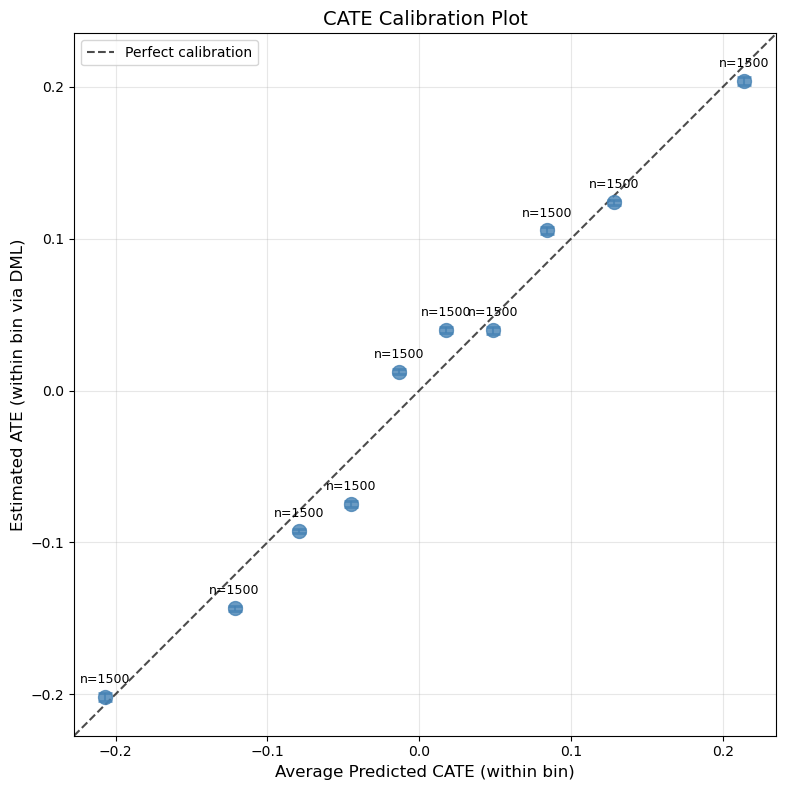

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from econml.dml import LinearDML, CausalForestDML
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy import stats


def cate_calibration_plot(
    fitted_model,
    X: np.ndarray,
    T: np.ndarray,
    Y: np.ndarray,
    n_bins: int = 5,
    method: str = 'quantile',
    model_class=None,
    model_kwargs: dict = None,
    ax=None,
    show_ci: bool = True,
    alpha: float = 0.05
):
    """
    Create a CATE calibration plot (reliability diagram).
    
    Parameters
    ----------
    fitted_model : econml estimator
        Already fitted CATE model (e.g., LinearDML, CausalForestDML)
    X : np.ndarray
        Features/covariates (n_samples, n_features)
    T : np.ndarray
        Treatment (continuous), shape (n_samples,)
    Y : np.ndarray
        Binary outcome, shape (n_samples,)
    n_bins : int
        Number of bins for grouping predicted CATEs
    method : str
        'quantile' for equal-sized bins, 'uniform' for equal-width bins
    model_class : class, optional
        econml model class for within-bin ATE estimation. 
        Defaults to same class as fitted_model.
    model_kwargs : dict, optional
        kwargs for the within-bin model. Defaults to fitted_model's config.
    ax : matplotlib.axes.Axes, optional
        Axes to plot on
    show_ci : bool
        Whether to show confidence intervals
    alpha : float
        Significance level for confidence intervals
        
    Returns
    -------
    results : dict
        Dictionary with bin statistics and plot data
    """
    
    # Get predicted CATEs
    cate_pred = fitted_model.effect(X).flatten()
    
    # Create bins
    if method == 'quantile':
        bin_edges = np.percentile(cate_pred, np.linspace(0, 100, n_bins + 1))
        # Handle duplicate edges
        bin_edges = np.unique(bin_edges)
        n_bins = len(bin_edges) - 1
    else:  # uniform
        bin_edges = np.linspace(cate_pred.min(), cate_pred.max(), n_bins + 1)
    
    # Assign bins
    bin_indices = np.digitize(cate_pred, bin_edges[1:-1])
    
    # Setup model for within-bin ATE estimation
    if model_class is None:
        model_class = type(fitted_model)
    
    if model_kwargs is None:
        # Try to extract reasonable defaults
        model_kwargs = {
            'model_y': RandomForestClassifier(n_estimators=100, min_samples_leaf=10),
            'model_t': RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            'discrete_treatment': False,
            'discrete_outcome': True,
            'cv': 2  # Fewer folds for smaller bin samples
        }
    
    # Compute statistics for each bin
    results = {
        'bin_avg_pred_cate': [],
        'bin_ate': [],
        'bin_ate_se': [],
        'bin_ate_ci_lower': [],
        'bin_ate_ci_upper': [],
        'bin_count': [],
        'bin_edges': bin_edges
    }
    
    for b in range(n_bins):
        mask = bin_indices == b
        n_in_bin = mask.sum()
        
        if n_in_bin < 50:  # Minimum samples for reliable estimation
            print(f"Warning: Bin {b} has only {n_in_bin} samples. Results may be unreliable.")
        
        # Average predicted CATE in this bin
        avg_pred = cate_pred[mask].mean()
        results['bin_avg_pred_cate'].append(avg_pred)
        results['bin_count'].append(n_in_bin)
        
        # Estimate actual ATE within this bin using DML
        X_bin = X[mask]
        T_bin = T[mask]
        Y_bin = Y[mask]
        
        try:
            # Fit DML on bin data to get ATE
            bin_model = model_class(**model_kwargs)
            bin_model.fit(Y_bin, T_bin, X=X_bin)
            
            # Get ATE (average effect across bin)
            bin_effects = bin_model.effect(X_bin)
            ate = bin_effects.mean()
            
            # Standard error via inference or bootstrap
            try:
                # Try to get inference from model
                inf = bin_model.effect_inference(X_bin)
                ate_se = inf.std_effect().mean() / np.sqrt(n_in_bin)
            except:
                # Fallback: bootstrap SE
                ate_se = bin_effects.std() / np.sqrt(n_in_bin)
            
            z = stats.norm.ppf(1 - alpha/2)
            ci_lower = ate - z * ate_se
            ci_upper = ate + z * ate_se
            
        except Exception as e:
            print(f"Warning: Could not estimate ATE for bin {b}: {e}")
            ate, ate_se, ci_lower, ci_upper = np.nan, np.nan, np.nan, np.nan
        
        results['bin_ate'].append(ate)
        results['bin_ate_se'].append(ate_se)
        results['bin_ate_ci_lower'].append(ci_lower)
        results['bin_ate_ci_upper'].append(ci_upper)
    
    # Convert to arrays
    for key in results:
        if key != 'bin_edges':
            results[key] = np.array(results[key])
    
    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    pred = results['bin_avg_pred_cate']
    actual = results['bin_ate']
    
    # Plot diagonal (perfect calibration)
    all_vals = np.concatenate([pred[~np.isnan(actual)], actual[~np.isnan(actual)]])
    lims = [all_vals.min() - 0.1 * abs(all_vals.min()), 
            all_vals.max() + 0.1 * abs(all_vals.max())]
    ax.plot(lims, lims, 'k--', alpha=0.7, label='Perfect calibration')
    
    # Plot points with error bars
    valid = ~np.isnan(actual)
    if show_ci:
        yerr = np.array([
            actual[valid] - results['bin_ate_ci_lower'][valid],
            results['bin_ate_ci_upper'][valid] - actual[valid]
        ])
        ax.errorbar(pred[valid], actual[valid], yerr=yerr, 
                    fmt='o', markersize=10, capsize=5, capthick=2,
                    color='steelblue', ecolor='steelblue', alpha=0.8)
    else:
        ax.scatter(pred[valid], actual[valid], s=100, color='steelblue', alpha=0.8)
    
    # Add bin count annotations
    for i, (x, y, n) in enumerate(zip(pred[valid], actual[valid], results['bin_count'][valid])):
        ax.annotate(f'n={n}', (x, y), textcoords="offset points", 
                    xytext=(0, 10), ha='center', fontsize=9)
    
    ax.set_xlabel('Average Predicted CATE (within bin)', fontsize=12)
    ax.set_ylabel('Estimated ATE (within bin via DML)', fontsize=12)
    ax.set_title('CATE Calibration Plot', fontsize=14)
    ax.legend(loc='upper left')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Compute calibration metrics
    valid_mask = ~np.isnan(actual)
    if valid_mask.sum() > 1:
        # Weighted calibration error
        weights = results['bin_count'][valid_mask] / results['bin_count'][valid_mask].sum()
        calibration_error = np.average(np.abs(pred[valid_mask] - actual[valid_mask]), weights=weights)
        results['weighted_calibration_error'] = calibration_error
        
        # Correlation
        results['correlation'] = np.corrcoef(pred[valid_mask], actual[valid_mask])[0, 1]
        
        # Slope of best fit line (should be ~1 for good calibration)
        slope, intercept = np.polyfit(pred[valid_mask], actual[valid_mask], 1)
        results['calibration_slope'] = slope
        results['calibration_intercept'] = intercept
    
    return results


# Example usage
if __name__ == "__main__":
    from sklearn.datasets import make_classification
    
    # Generate synthetic data
    np.random.seed(42)
    n = 15000
    p = 10
    
    X = np.random.randn(n, p)
    T = np.random.randn(n)  # Continuous treatment
    
    # True CATE varies with X
    true_cate = 0.5 * X[:, 0] + 0.3 * X[:, 1]
    
    # Binary outcome with treatment effect
    prob = 1 / (1 + np.exp(-(0.5 + T * true_cate + 0.2 * X[:, 2])))
    Y = np.random.binomial(1, prob)
    
    # Fit DML model
    from econml.dml import LinearDML
    
    model = LinearDML(
        model_y=RandomForestClassifier(n_estimators=100, min_samples_leaf=20),
        model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=20),
        discrete_treatment=False,
        discrete_outcome=True,
        cv=3
    )
    model.fit(Y, T, X=X)
    
    # Create calibration plot
    results = cate_calibration_plot(
        fitted_model=model,
        X=X,
        T=T,
        Y=Y,
        n_bins=10,
        method='quantile',
        show_ci=True
    )
    
    print(f"\nCalibration Metrics:")
    print(f"  Weighted Calibration Error: {results.get('weighted_calibration_error', 'N/A'):.4f}")
    print(f"  Correlation: {results.get('correlation', 'N/A'):.4f}")
    print(f"  Calibration Slope: {results.get('calibration_slope', 'N/A'):.4f} (ideal: 1.0)")
    print(f"  Calibration Intercept: {results.get('calibration_intercept', 'N/A'):.4f} (ideal: 0.0)")
    
    plt.show()